# Анализ результатов эксперимента от 15.09.25

In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Описание эксперимента

Тестировалось усреднение показателей за N шагом и разные функции награды: относительная и абсолютная.

## Результаты

In [ ]:
from pathlib import Path

EXPERIMENT_NAME = "relative_skip1"
EXPERIMENT_DATE = "2025-09-15"
EXPERIMENT_TIME = "18-20-38"

EXPERIMENT_NAME = "relative_skip50"
EXPERIMENT_DATE = "2025-09-15"
EXPERIMENT_TIME = "19-04-16"

EXPERIMENT_NAME = "absolute_skip50"
EXPERIMENT_DATE = "2025-09-15"
EXPERIMENT_TIME = "17-45-50"

PATH_TO_EXP_DIR = Path(f"../experiments/{EXPERIMENT_NAME}/{EXPERIMENT_DATE}/{EXPERIMENT_TIME}")

LOG_TRAIN_DIR = PATH_TO_EXP_DIR / "train_logs"
LOG_ENV_DIR = PATH_TO_EXP_DIR / "env_logs"

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_tensorboard_df(ax, df, tags=None, title="Training curves"):
    for tag in tags:
        sns.lineplot(data=df, x="step", y=tag, ax=ax, label=tag)
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Step")
    ax.set_ylabel("Value")
    ax.legend(title="Metric")

In [34]:
from nn_laser_stabilizer.utils import tensorboard_to_df

train_df = tensorboard_to_df(str(LOG_TRAIN_DIR))

Tensorboard содержит не все данные: количество step значительно количества точек.

In [35]:
print(train_df.info())
print(train_df["step"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   step         10000 non-null  int64  
 1   Loss/Actor   10000 non-null  float64
 2   Loss/Critic  10000 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 234.5 KB
None
0           2
1           5
2           7
3          10
4          15
        ...  
9995    20882
9996    20888
9997    20890
9998    20894
9999    20901
Name: step, Length: 10000, dtype: int64


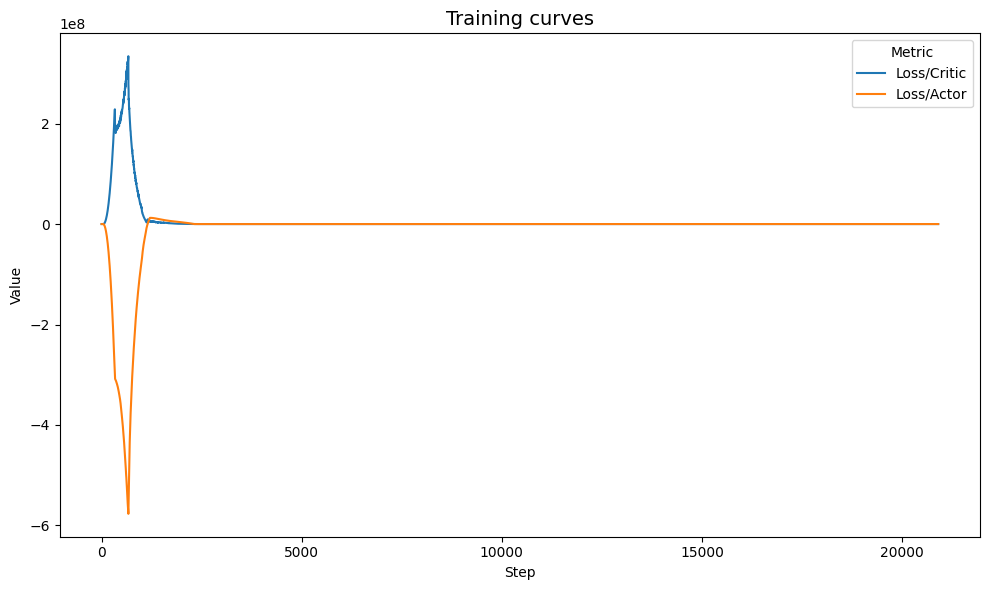

In [36]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_tensorboard_df(ax, train_df, tags=["Loss/Critic", "Loss/Actor"], title="Training curves")
plt.tight_layout()
plt.savefig(LOG_TRAIN_DIR / "train_logs.pdf")

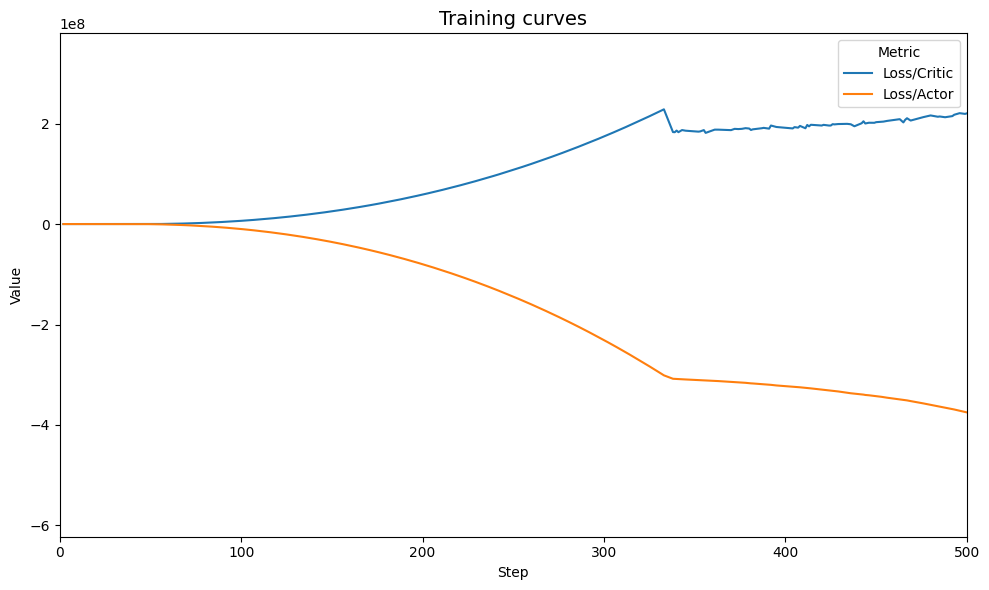

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(left=0, right=500)
plot_tensorboard_df(ax, train_df, tags=["Loss/Critic", "Loss/Actor"], title="Training curves")
plt.tight_layout()
plt.savefig(LOG_TRAIN_DIR / "train_logs_first_steps.pdf")

In [38]:
import pandas as pd
import re

def parse_pid_log(file_path: str) -> pd.DataFrame:
    pattern = re.compile(
        r"step=(\d+)\s+kp=([-+]?\d*\.\d+|\d+)\s+ki=([-+]?\d*\.\d+|\d+)\s+kd=([-+]?\d*\.\d+|\d+)\s+"
        r"x=([-+]?\d*\.\d+|\d+)\s+control_output=([-+]?\d*\.\d+|\d+)\s+setpoint=([-+]?\d*\.\d+|\d+)"
    )

    data = []
    with open(file_path, "r") as f:
        for line in f:
            match = pattern.search(line)
            if match:
                data.append([
                    int(match.group(1)),      # step
                    float(match.group(2)),    # kp
                    float(match.group(3)),    # ki
                    float(match.group(4)),    # kd
                    float(match.group(5)),    # x
                    float(match.group(6)),    # control_output
                    float(match.group(7))     # setpoint
                ])

    df = pd.DataFrame(data, columns=[
        "step", "Action/kp", "Action/ki", "Action/kd", "Observation/x", "Observation/control_output", "Observation/setpoint"
    ])
    df["reward"] = -abs(df["Observation/setpoint"] - df["Observation/x"]) + 1
    return df

In [39]:
env_df = parse_pid_log(str(LOG_ENV_DIR / "log.txt"))

In [40]:
from nn_laser_stabilizer.envs.normalization import denormalize_adc, denormalize_dac

# Делаем обратное преобразование для графика
env_df["Observation/x"] = env_df["Observation/x"].apply(denormalize_adc)
env_df["Observation/setpoint"] = env_df["Observation/setpoint"].apply(denormalize_adc)

env_df["Observation/control_output"] = env_df["Observation/control_output"].apply(denormalize_dac)

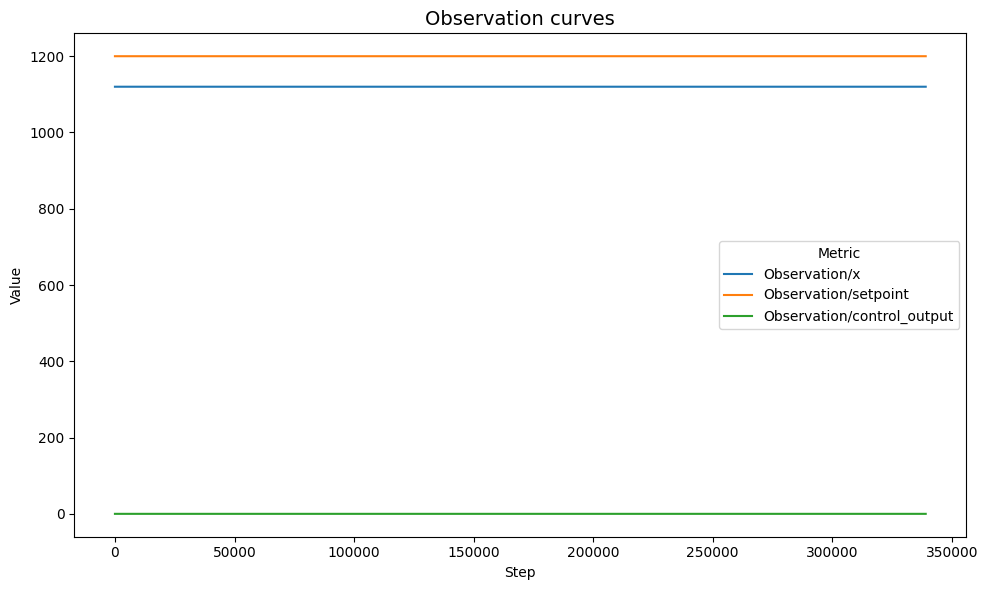

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_tensorboard_df(ax, env_df, tags=["Observation/x", "Observation/setpoint", "Observation/control_output"], title="Observation curves")
plt.tight_layout()
plt.savefig(LOG_ENV_DIR / "observation_logs.pdf")

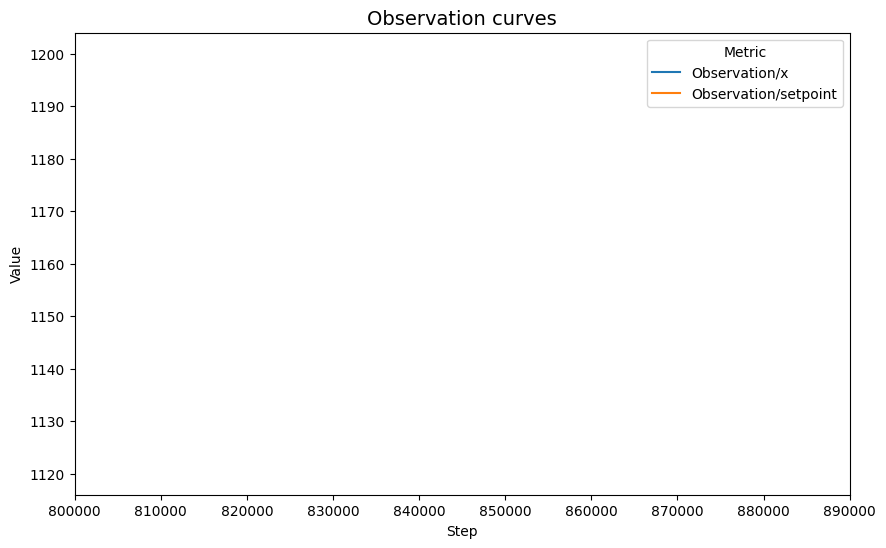

In [42]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(left=800_000, right=890_000)
plot_tensorboard_df(ax, env_df, tags=["Observation/x", "Observation/setpoint"], title="Observation curves")
fig.savefig(LOG_ENV_DIR / "observation_logs_last_steps.pdf")

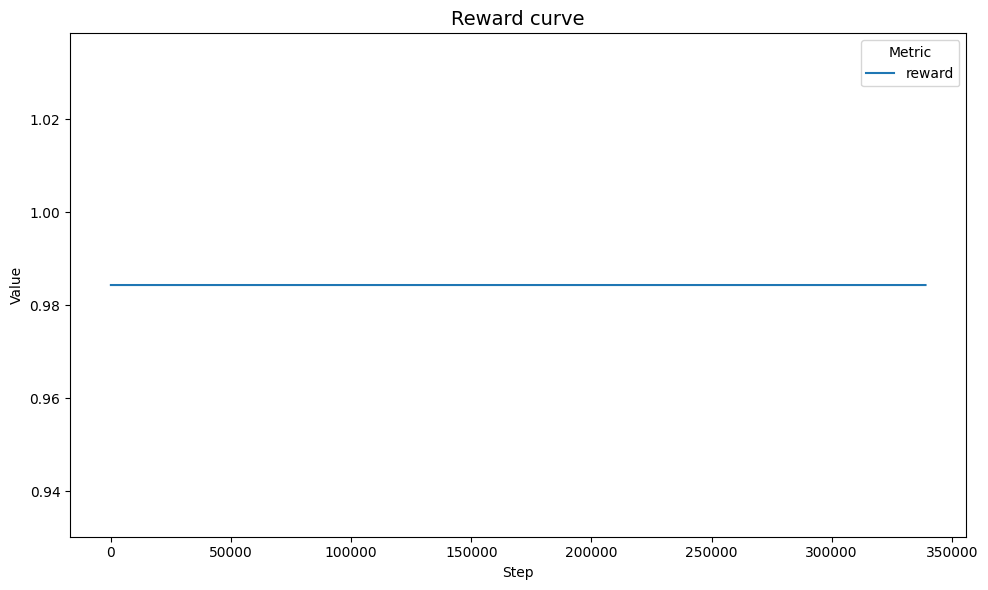

In [43]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_tensorboard_df(ax, env_df, tags=["reward"], title="Reward curve")
plt.tight_layout()
plt.savefig(LOG_ENV_DIR / "reward_logs.pdf")

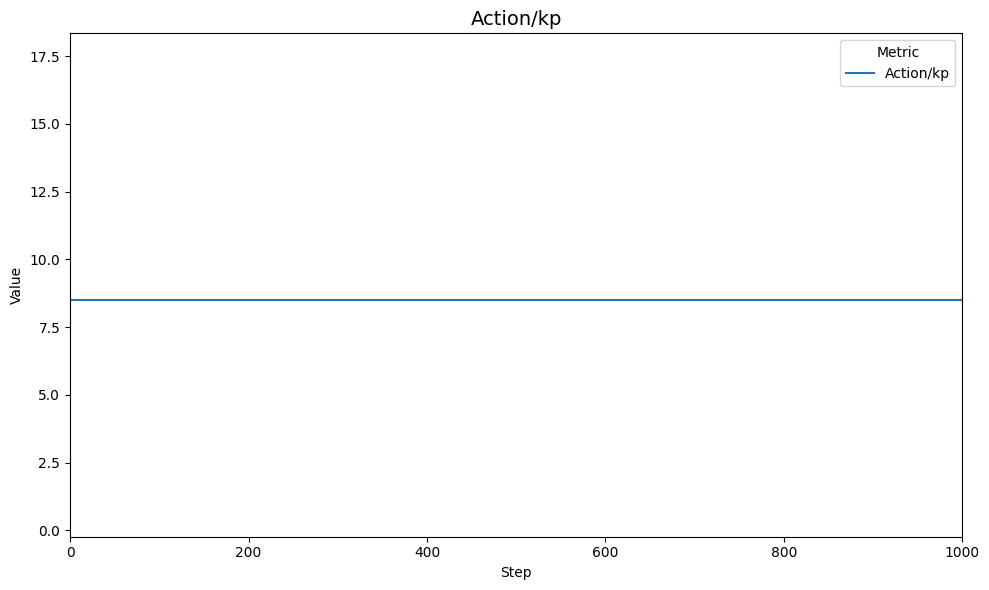

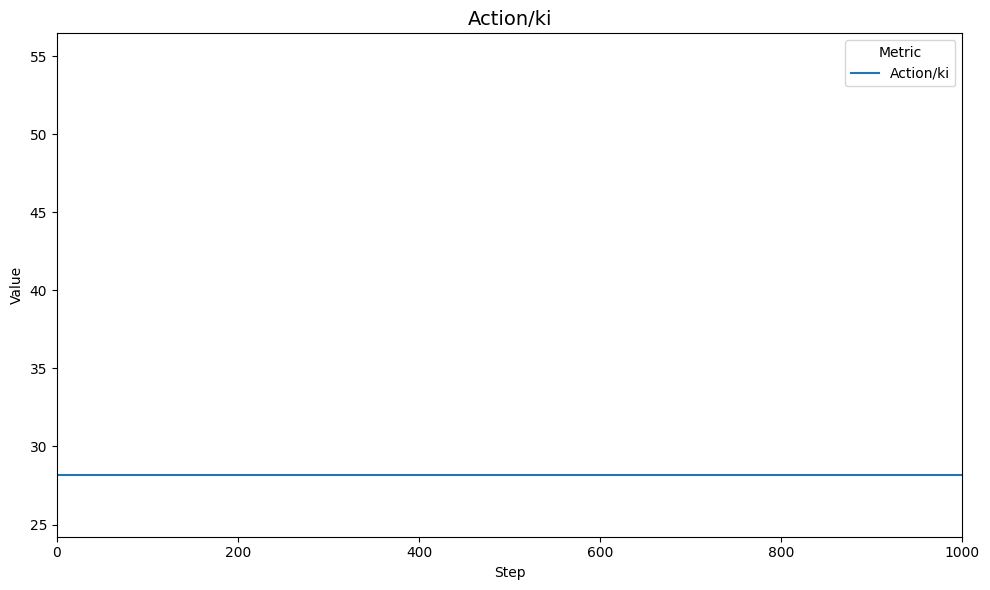

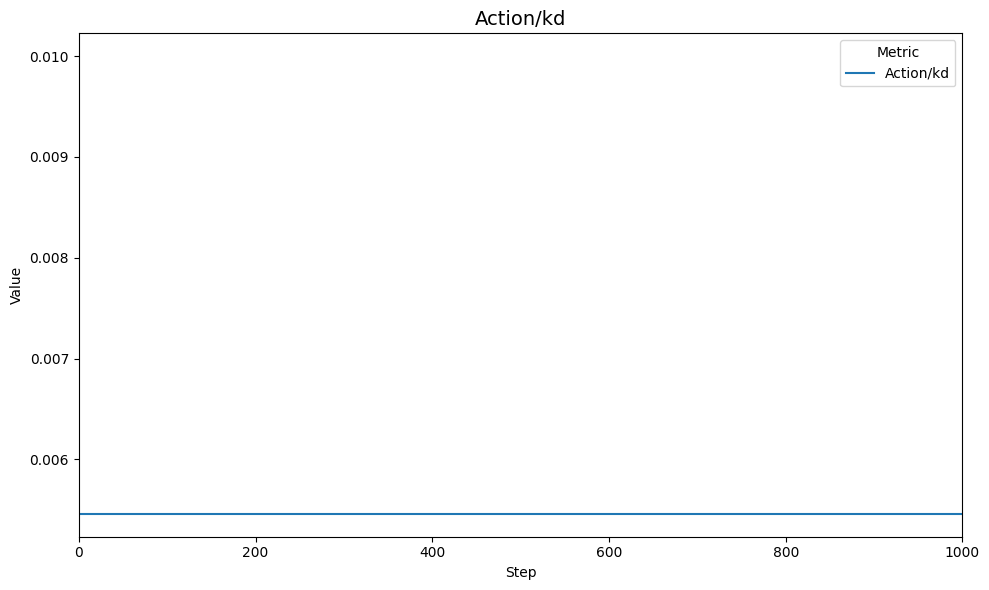

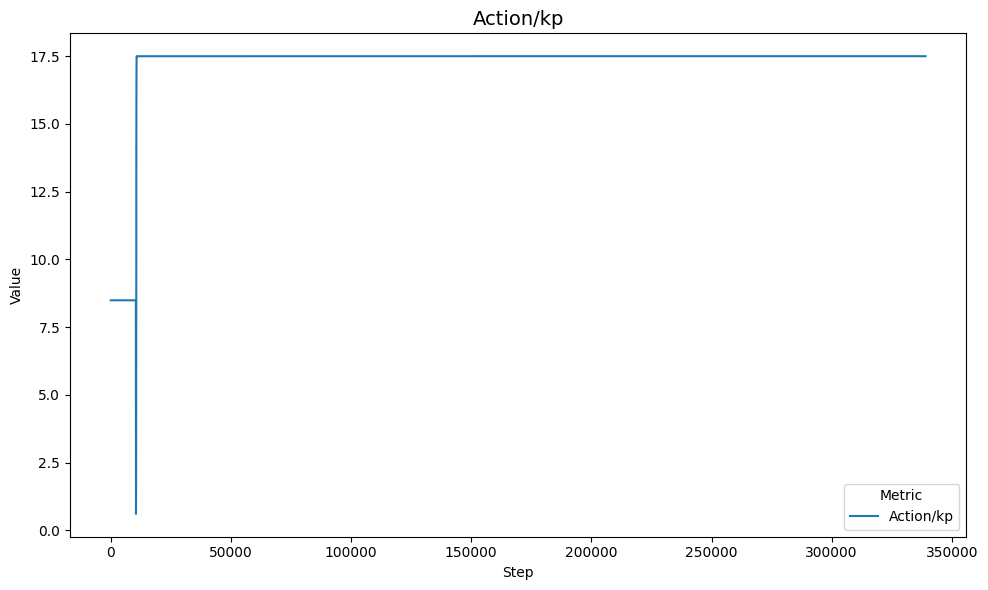

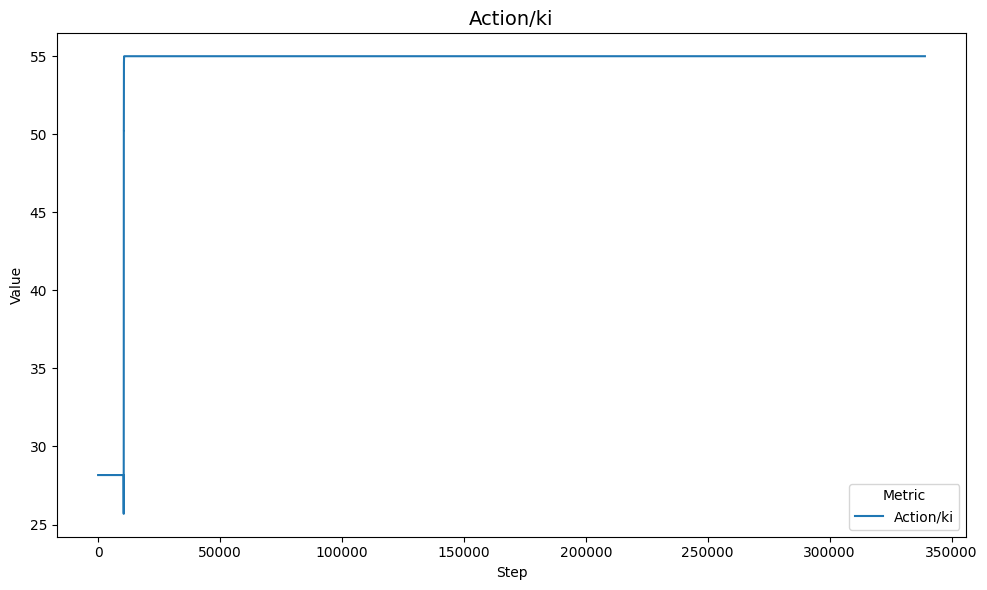

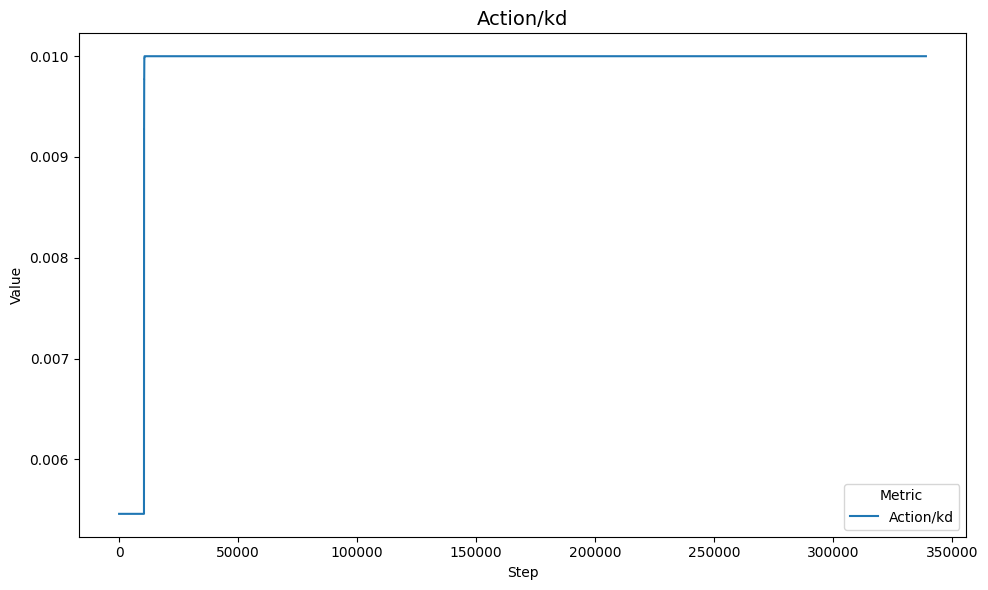

In [44]:
action_tags = ["Action/kp", "Action/ki", "Action/kd"]

for tag in action_tags:
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlim(0, 1000)

    plot_tensorboard_df(ax, env_df, tags=[tag], title=tag)

    plt.tight_layout()
    plt.savefig(LOG_ENV_DIR / f"{tag.replace('/', '_')}_first_steps.pdf")

for tag in action_tags:
    fig, ax = plt.subplots(figsize=(10, 6))

    plot_tensorboard_df(ax, env_df, tags=[tag], title=tag)

    plt.tight_layout()
    plt.savefig(LOG_ENV_DIR / f"{tag.replace('/', '_')}.pdf")